# What is Pneumonia?
**Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli.Symptoms typically include some combination of productive or dry cough, chest pain, fever and difficulty breathing. The severity of the condition is variable. Pneumonia is usually caused by infection with viruses or bacteria and less commonly by other microorganisms, certain medications or conditions such as autoimmune diseases.Risk factors include cystic fibrosis, chronic obstructive pulmonary disease (COPD), asthma, diabetes, heart failure, a history of smoking, a poor ability to cough such as following a stroke and a weak immune system. Diagnosis is often based on symptoms and physical examination. Chest X-ray, blood tests, and culture of the sputum may help confirm the diagnosis.The disease may be classified by where it was acquired, such as community- or hospital-acquired or healthcare-associated pneumonia.**


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Importing the necessary libraries

In [2]:
import numpy as np # linear algebra
import pandas as pd # 
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [3]:
# labels =['PNEUMONIA','NORMAL']
# img_size = 150
# def get_training_data(data_dir):
#     data = []
#     for label in labels:
#         path = os.path.join(data_dir,label)
#         class_num = labels.index(label)
#         for img in os.listdir(path):
#             try:
#                 img_arr = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
#                 resized_arr = cv2.resize(img_arr,(img_size,img_size))
#                 data.append([resized_arr,class_num])
#             except Exception as e:
#                 print(e)
#     return np.array(data)
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)
                
        

# Loading the Dataset

In [4]:
train = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/train')
val = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/val')
test = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/test')

OpenCV(4.5.4) /tmp/pip-req-build-jpmv6t9_/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.5.4) /tmp/pip-req-build-jpmv6t9_/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


OpenCV(4.5.4) /tmp/pip-req-build-jpmv6t9_/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.5.4) /tmp/pip-req-build-jpmv6t9_/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



**Previewing the images of both the classes**

Text(0.5, 1.0, 'NORMAL')

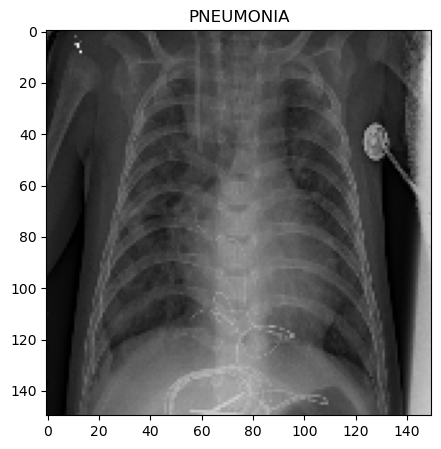

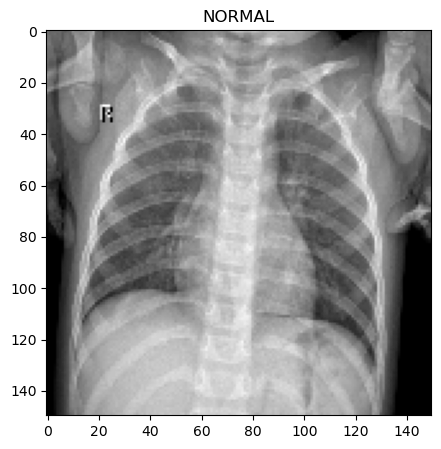

In [5]:
plt.figure(figsize=(5,5))
plt.imshow(train[0][0], cmap = 'gray')
plt.title(labels[train[0][1]])

plt.figure(figsize=(5,5))
plt.imshow(train[-1][0], cmap = 'gray')
plt.title(labels[train[-1][1]])

In [6]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test =[]
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)
    

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)
    
for feature, label in train:
    x_test.append(feature)
    y_test.append(label)
    

**We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].**

In [7]:
x_train = np.array(x_train)/255
x_val = np.array(x_val)/255
x_test = np.array(x_test)/255

In [8]:
x_train = x_train.reshape(-1,img_size,img_size,1)
y_train = np.array(y_train)
y_train
x_val = x_val.reshape(-1,img_size,img_size,1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1,img_size,img_size,1)
y_test = np.array(y_test)

# Data Augmentation
**In order to avoid overfitting problem, we need to expand artificially our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations.
Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.
By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.**

In [9]:
datagen = ImageDataGenerator(featurewise_center=False,
                             samplewise_center=False, 
                             featurewise_std_normalization=False,
                             samplewise_std_normalization=False, 
                             zca_whitening=False, 
                             zca_epsilon=1e-6, 
                             rotation_range=30, 
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             brightness_range=None,
                             shear_range=0.0,
                             zoom_range=0.2,
                             channel_shift_range=0.0,
                             fill_mode="nearest",
                             cval=0.0,
                             horizontal_flip=True,
                             
)
datagen.fit(x_train)

For the data augmentation, i choosed to :
1. Randomly rotate some training images by 30 degrees 
2. Randomly Zoom by 20% some training images
3. Randomly shift images horizontally by 10% of the width 
4. Randomly shift images vertically by 10% of the height 
5. Randomly flip images horizontally.
Once our model is ready, we fit the training dataset.

# Training the Model

In [10]:
model = Sequential()
model.add(Conv2D(32,(3,3),strides = 1, activation='relu',padding = 'same',input_shape=(150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2),strides = 2,padding='same'))
model.add(Conv2D(64,(3,3),strides = 1, activation='relu',padding = 'same'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2),strides = 2,padding='same'))
model.add(Conv2D(64,(3,3),strides = 1, activation='relu',padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2),strides = 2,padding='same'))
model.add(Conv2D(128,(3,3),strides = 1, activation='relu',padding = 'same'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2),strides = 2,padding='same'))
model.add(Conv2D(256,(3,3),strides = 1, activation='relu',padding = 'same'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2),strides = 2,padding='same'))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='rmsprop',loss = 'binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       2

In [11]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',factor=0.3,patience=2,min_lr=0.000001,verbose = 1)

In [12]:
history = model.fit(datagen.flow(x_train,y_train,batch_size=32),epochs = 12, validation_data= datagen.flow(x_val,y_val), callbacks=[learning_rate_reduction])

Epoch 1/12


2023-04-05 12:35:57.843909: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


163/163 [==============================] - 16s 66ms/step - loss: 0.5535 - accuracy: 0.8298 - val_loss: 37.0530 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/12
163/163 [==============================] - 11s 66ms/step - loss: 0.2633 - accuracy: 0.8965 - val_loss: 63.0768 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/12
163/163 [==============================] - ETA: 0s - loss: 0.2175 - accuracy: 0.9193
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 10s 63ms/step - loss: 0.2175 - accuracy: 0.9193 - val_loss: 16.4342 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/12
163/163 [==============================] - 10s 63ms/step - loss: 0.1442 - accuracy: 0.9467 - val_loss: 17.9043 - val_accuracy: 0.5625 - lr: 3.0000e-04
Epoch 5/12
163/163 [==============================] - 11s 66ms/step - loss: 0.1383 - accuracy: 0.9538 - val_loss: 9.2259 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 6/12
163/163 [==============================] -

In [13]:
predictions = model.predict(x_val)
predicted_classes = np.argmax(predictions, axis=1)
predicted_classes[:15]

1/1 [==============================] - 0s 171ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [14]:
model.evaluate(x_test,y_test)

163/163 [==============================] - 1s 7ms/step - loss: 0.2722 - accuracy: 0.8863


[0.27219855785369873, 0.8863113522529602]

# Analysis after Model Training

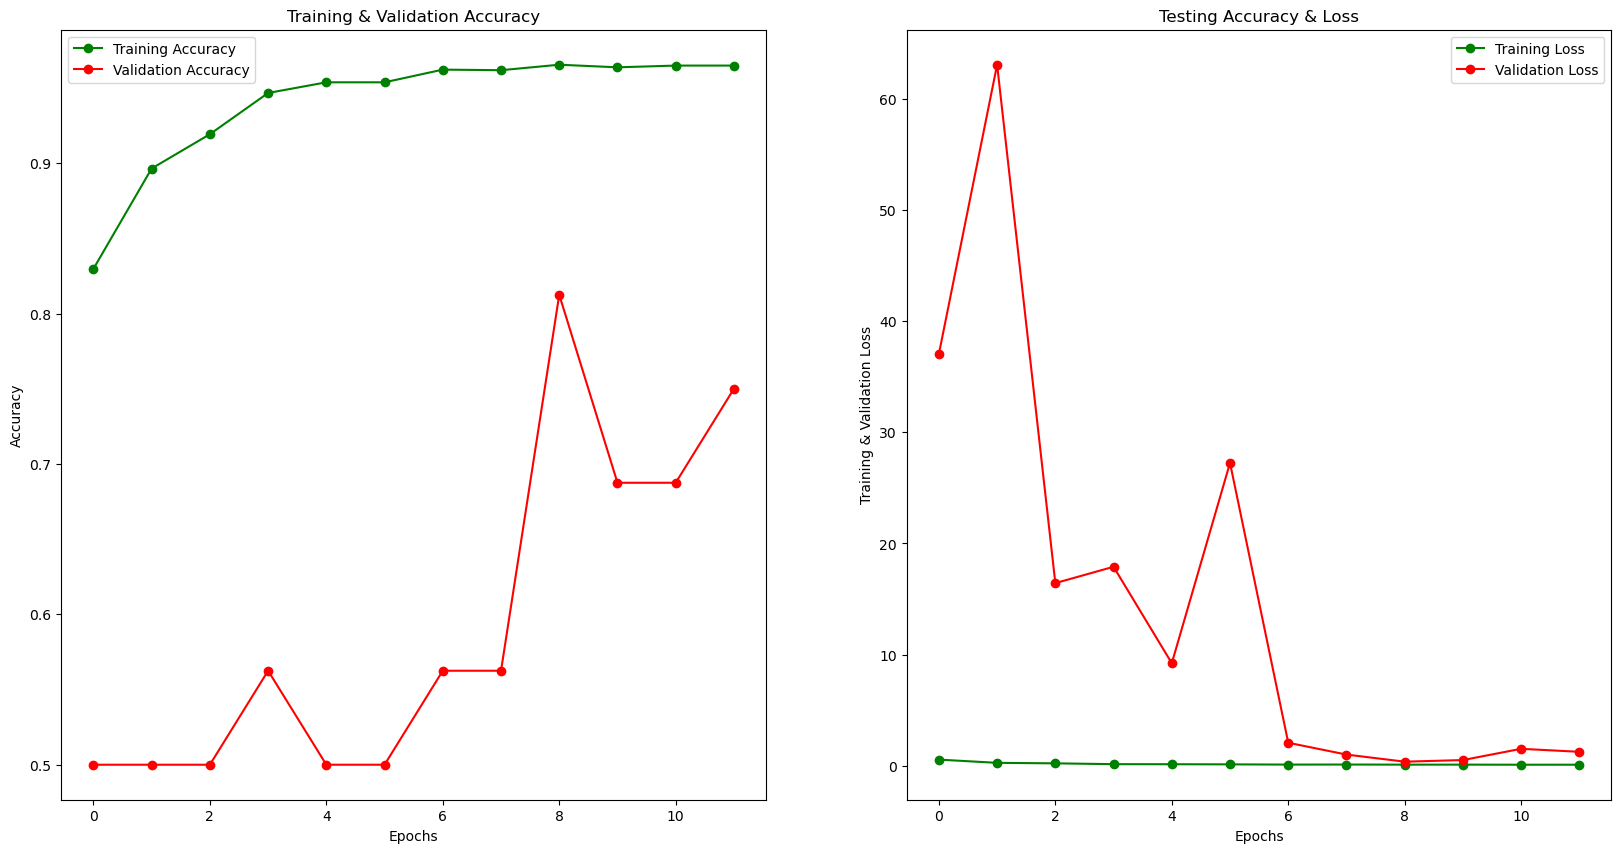

In [15]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [16]:
pred = model.predict(x_val)
# predictions = predictions.reshape(1,-1)[0]
pred = np.where(pred < 0.5,1,0)
pred[:15]
cm = confusion_matrix(y_val,pred)
cm

1/1 [==============================] - 0s 21ms/step


array([[2, 6],
       [7, 1]])

In [17]:
predictions = model.predict(x_test)
# predictions = predictions.reshape(1,-1)[0]
predictions = np.where(predictions < 0.5,1,0)
predictions[:15]

163/163 [==============================] - 1s 5ms/step


array([[1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0]])

In [18]:
cm = confusion_matrix(y_test,predictions)

In [19]:
cm = pd.DataFrame(cm, index = [0,1], columns = [0,1])

In [20]:
cm

,0,1
0,588,3287
1,1336,5


<AxesSubplot:>

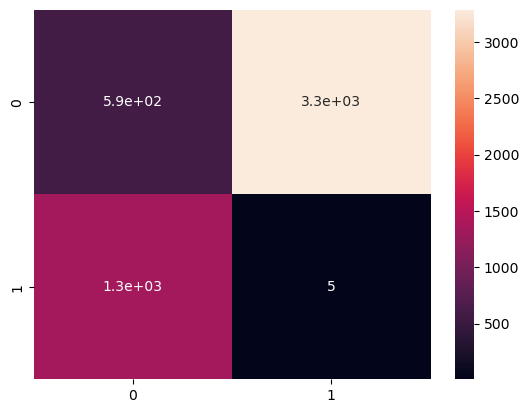

In [21]:
sns.heatmap(cm,annot=True)

In [22]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

**Some of the Correctly Predicted Classes**

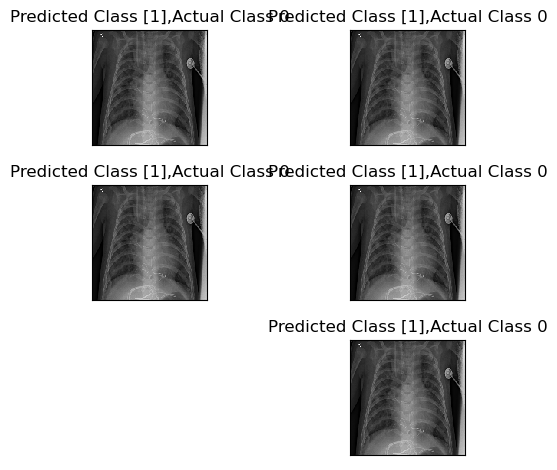

In [23]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

**Some of the Incorrectly Predicted Classes**

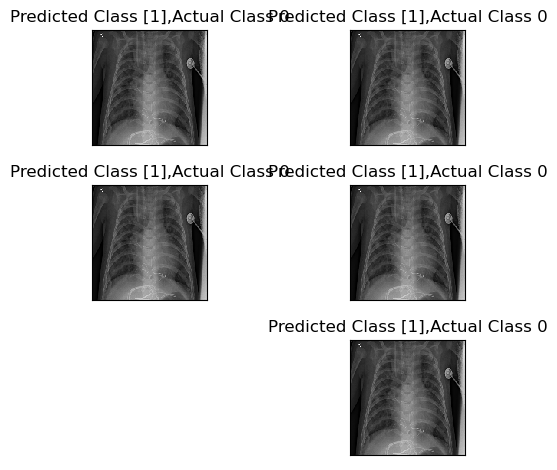

In [24]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1